>Let's try using a Random Forest on the same training data to see how that affects performance.

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators= 100, random_state= 50, verbose= 1, n_jobs= -1)

In [2]:
FILE_NAME = "preprocess.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))
app_train = pd.read_csv( PARENT_DIR + '/data/processed_train.csv')
app_test = pd.read_csv( PARENT_DIR + '/data/processed_test.csv')



In [3]:
# Drop the target from training data

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()



train_labels = app_train['TARGET']

In [4]:
# Train on the training data
# random_forest.fit(train, train_labels)

# the error below is not a big deal, 
# we now know the rf does not allow NaN,
# we'll fix the bug afterwise


In [5]:
# Still use the median strategy 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# Drop the target from training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data 
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1 (Normalization)
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
imputer.fit(train)

# Transform both training data and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeate with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape:', train.shape)
print('Testing data shape:', test.shape)



Training data shape: (307511, 241)
Testing data shape: (48744, 241)


In [6]:
# Train on the training data
random_forest.fit(train, train_labels)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [7]:
train[:20]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.25192677e-06, 2.80699391e-06, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.50385353e-06, 5.61398781e-06, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.52827550e-05, 5.33328842e-05, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.85346818e-05, 5.61398781e-05, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.17866086e-05, 5.89468720e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


In [9]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission to a csv file
FILE_NAME = "preprocess.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))


submit.to_csv(PARENT_DIR + '/result/random_forest_baseline.csv', index = False)

In [10]:
# calculate the accuracy
from sklearn.model_selection import train_test_split

# 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size = 0.3, stratify = train_labels)
X_train



array([[0.62980716, 0.63040031, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.42113427, 0.42162171, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.56388735, 0.56404016, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.14851875, 0.14849559, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.5340997 , 0.5344348 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.37040747, 0.37080389, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
# retraining
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features,
                                    'importance': feature_importance_values})

# Make predictions on the test data
predictions_val = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished


In [12]:
predictions_val.shape

(92254,)

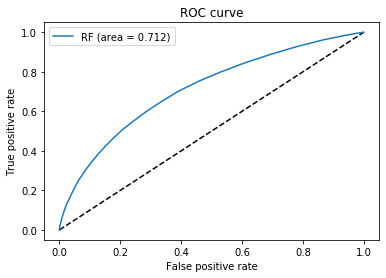

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, predictions_val)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 正确率在0.712左右